To implement a decision tree classifier and use it to classify whether
the person has heart disease or not. There are 14 features in the dataset, with the final column for target with values as either 0 or 1. Use max depth as an early stopping criteria. If no max depth is specified you model should train the whole tree.

### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import math
import subprocess
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import warnings
%matplotlib inline
from collections import Counter
warnings.filterwarnings('ignore')

### Importing Dataset

In [ ]:
h_data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/heart.csv')

### Creating Train and Test data and their axes

# Question 1:
Implement the classifier using information gain and gini index. Compute and compare the accuracy of the model for different options. Set max depth as 3, max split as 5 and train-test split as 70%. Compare the results with the logistic regression and decision tree classifier
available in scikit learn library.

### For 70% training size, the test size will be 30% and train test split will be 0.3.

## Implementation of Decision Tree Algorithm using information gain(Class MyDecisionTree)

In [ ]:
#fuction for entropy
def entropy(j):
    return -np.sum([i * np.log2(i) for i in (np.bincount(j) / len(j)) if i > 0])

In [ ]:
# Defining node for the tree
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.value = value
        self.left = left
        self.right = right    

    def is_leaf_node(self):#to check for leaf node
        return self.value is not None

In [ ]:
class MyDecisionTree:

    def __init__(self, min_samples_split=5, max_depth=3, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # stopping criteria
        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
       
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = entropy(y)
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # information gain is difference in loss before vs. after split
        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)
        if(len(most_common) > 0):
            most_common = most_common[0][0]
        else:
            most_common = 0.0
        return most_common   

## Implementation of Decision Tree Algorithm using Gini Index(Class MyDecisionTreeGini)

In [ ]:
#fuction for sum of sqaure
def sumofsq(j):
    return 1-np.sum([i * i for i in (np.bincount(j) / len(j)) if i > 0])

In [ ]:
class MyDecisionTreeGini:

    def __init__(self, min_samples_split=5, max_depth=3, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth
                or n_labels == 1
                or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)
        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._gini_index(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _gini_index(self, y, X_column, split_thresh):
        parent_sumofsq = sumofsq(y)
        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = sumofsq(y[left_idxs]), sumofsq(y[right_idxs])
        child_sumofsq = (n_l / n) * e_l + (n_r / n) * e_r
        ig =parent_sumofsq-child_sumofsq 
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)
        if(len(most_common) > 0):
            most_common = most_common[0][0]
        else:
            most_common = 0.0
        return most_common   

In [ ]:
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [ ]:
X = h_data.drop(['target'], axis = 1)
y = h_data['target']
dataset = X.to_numpy()
X = np.array(dataset[:,:-1], dtype=np.float64)
y = np.array(dataset[:,-1], dtype=np.int64)

### Manual Decision Tree Accuracy with Information gain



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
my_decision = MyDecisionTree(max_depth=3, min_samples_split=5)
my_decision.fit(X_train, y_train)
y_pred = my_decision.predict(X_test)
accuracy_1 = accuracy(y_test, y_pred)
print ("Manual Decision Tree Accuracy with information gain:", accuracy_1)

Manual Decision Tree Accuracy with information gain: 0.6373626373626373


### Manual Decision Tree Accuracy with Gini Index

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
my_decision_gini = MyDecisionTreeGini(max_depth=3, min_samples_split=5)
my_decision_gini.fit(X_train, y_train)
y_pred = my_decision_gini.predict(X_test)
accuracy_11 = accuracy(y_test, y_pred)
print ("Manual Decision Tree Accuracy with gini index:", accuracy_11)

Manual Decision Tree Accuracy with gini index: 0.5824175824175825


### sklearn Decision Tree Accuracy (Information Entropy Criteria)

In [ ]:
sk_decision = DecisionTreeClassifier(criterion='entropy',max_depth =3 ,min_samples_split=5)
sk_decision.fit(X_train, y_train)
y_pred = sk_decision.predict(X_test)
accuracy_2 = sk_decision.score(X_train, y_train)
print ("sklearn Decision Tree Accuracy with information:", accuracy_2)

sklearn Decision Tree Accuracy with information: 0.6933962264150944


### sklearn Decision Tree Accuracy (Gini Index Criteria)

In [ ]:
sk_decision = DecisionTreeClassifier(criterion='gini',max_depth =3 ,min_samples_split=5)
sk_decision.fit(X_train, y_train)
y_pred = sk_decision.predict(X_test)
accuracy_21 = sk_decision.score(X_train, y_train)
print ("sklearn Decision Tree Accuracy with gini index:", accuracy_21)

sklearn Decision Tree Accuracy with gini index: 0.7452830188679245


### Logistic Regression Tree Accuracy

In [ ]:
logistic_regr = LogisticRegression(random_state = 0)
logistic_regr.fit(X_train, y_train)
y_pred = logistic_regr.predict(X_test)
accuracy_3 = logistic_regr.score(X_train, y_train)
print ("Logistic Regression Tree Accuracy:", accuracy_3)

Logistic Regression Tree Accuracy: 0.7264150943396226


# Comparison of results

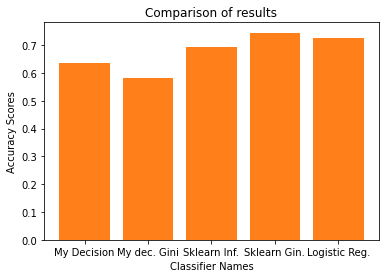

In [ ]:
accuracy = [accuracy_1,accuracy_11, accuracy_2,accuracy_21, accuracy_3]
bars = ('My Decision', 'My dec. Gini','Sklearn Inf.','Sklearn Gin.', 'Logistic Reg.')
plt.bar(bars, accuracy, color = (1.0,0.5,0.1))
plt.title('Comparison of results')
plt.xlabel('Classifier Names')
plt.ylabel('Accuracy Scores')
plt.show()

# Question 2 (1):
Train the model with [50, 55, 60, 65, 70, 75, 80, 85, 90, 95]% of data as the training data, i.e. increase the percentage by 5% and find the corresponding accuracy. Do you see overfitting? Plot accuracy wrt the training data.

## For Information Gain

In [ ]:
X = h_data.drop(['target'], axis = 1)
y = h_data['target']
dataset = X.to_numpy()
X = np.array(dataset[:,:-1], dtype=np.float64)
y = np.array(dataset[:,-1], dtype=np.int64)
def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

In [ ]:
decision_scores = []
for i in range(50, 100,5):#For incrementing 5% till 95% as 100 is explicit from the loop
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (100-i)/100, random_state = 0)#For different train size
    my_decision = MyDecisionTree(max_depth=3, min_samples_split=5)
    my_decision.fit(X_train, y_train)
    y_pred = my_decision.predict(X_test)
    accuracy_1 = accuracy(y_test, y_pred)
    decision_scores.append(accuracy_1)

# Finding Corresponding Accuracy Scores(With different training sizes)

In [ ]:
decision_scores

[0.5526315789473685,
 0.7007299270072993,
 0.5819672131147541,
 0.5981308411214953,
 0.5714285714285714,
 0.5657894736842105,
 0.5573770491803278,
 0.5,
 0.6774193548387096,
 0.6875]

# Answer(For Overfitting):
After looking at the accuracy scores, in my opinion the model is overfitting as there is sudden increase in accuracy as we increase training size. Before 85% it was going for unknown fit.

# Plotting accuracy with respect to data

Text(0.5, 1.0, 'Decision Tree Classifier scores for different train test splits')

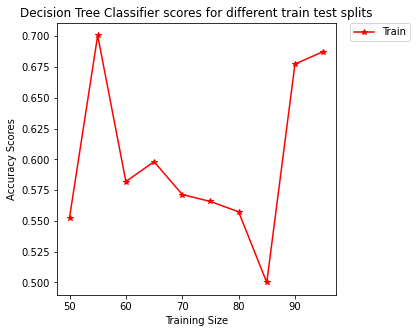

In [ ]:
plt.figure(figsize =(5, 5)) 
plt.plot([i for i in range(50, 100,5)], decision_scores, marker='*', color = 'red', label='Train')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Training Size')
plt.ylabel('Accuracy Scores')
plt.title('Decision Tree Classifier scores for different train test splits')

## For Gini Index

In [ ]:
decision_scores = []
for i in range(50,100,5):#For incrementing 5% till 95 as 100 is explicit from the loop
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (100-i)/100, random_state = 0)
    my_decision = MyDecisionTree(max_depth=3, min_samples_split=5)#For different train sizes
    my_decision.fit(X_train, y_train)
    y_pred = my_decision.predict(X_test)
    accuracy_1 = accuracy(y_test, y_pred)
    decision_scores.append(accuracy_1)

# Finding Corresponding Accuracy Scores(With different training sizes)

In [ ]:
print(decision_scores)

[0.5526315789473685, 0.7007299270072993, 0.5819672131147541, 0.5981308411214953, 0.5714285714285714, 0.5657894736842105, 0.5573770491803278, 0.5, 0.6774193548387096, 0.6875]


Text(0.5, 1.0, 'Decision Tree Classifier scores for different train test splits')

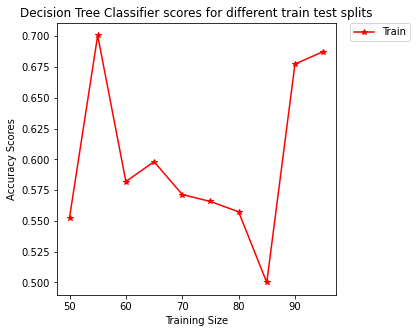

In [ ]:
plt.figure(figsize =(5, 5)) 
plt.plot([i for i in range(50, 100,5)], decision_scores, marker='*', color = 'red', label='Train')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Training Size')
plt.ylabel('Accuracy Scores')
plt.title('Decision Tree Classifier scores for different train test splits')

# Answer(For Overfitting):
Same as in information gain case, the model is overfitting as there is sudden increase in accuracy as we increase training size. Before 85% it was going for unknown fit.

# Question 2 (2):
Train the model with [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] max depth, and find the corresponding accuracy. Plot accuracy wrt the max depth.

## For Information Gain

In [ ]:
decision_depth_scores = []
for i in range(1,11):#For incrementing 1 till 10 as 11 is explicit from the loop
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
    my_decision = MyDecisionTree(max_depth=i, min_samples_split=5)#For different max depths
    my_decision.fit(X_train, y_train)
    y_pred = my_decision.predict(X_test)
    accuracy_1 = accuracy(y_test, y_pred)
    decision_depth_scores.append(accuracy_1)

# Finding Corresponding Accuracy Scores(With different max depths)

In [ ]:
decision_depth_scores

[0.5494505494505495,
 0.5494505494505495,
 0.5714285714285714,
 0.5164835164835165,
 0.5164835164835165,
 0.4835164835164835,
 0.5054945054945055,
 0.46153846153846156,
 0.4945054945054945,
 0.5164835164835165]

# Plotting accuracy with respect to data

Text(0.5, 1.0, 'Decision Tree Classifier scores for different Max Depths')

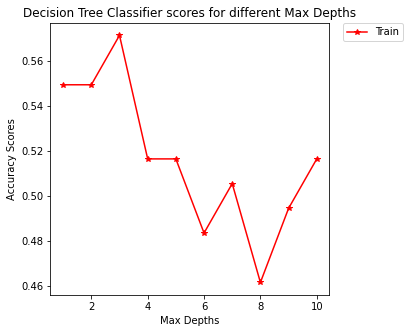

In [ ]:
plt.figure(figsize =(5, 5)) 
plt.plot([i for i in range(1,11)], decision_depth_scores, marker='*', color = 'red', label='Train')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.ylabel('Accuracy Scores')
plt.title('Decision Tree Classifier scores for different Max Depths')

## For Gini Index

In [ ]:
decision_depth_scores = []
for i in range(1,11):#For incrementing 1 till 10 as 11 is explicit from the loop
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
    my_decision = MyDecisionTreeGini(max_depth=i, min_samples_split=5)#For different max depths
    my_decision.fit(X_train, y_train)
    y_pred = my_decision.predict(X_test)
    accuracy_1 = accuracy(y_test, y_pred)
    decision_depth_scores.append(accuracy_1)

# Finding Corresponding Accuracy Scores(With different max depths)

In [ ]:
decision_depth_scores

[0.5494505494505495,
 0.5714285714285714,
 0.5494505494505495,
 0.5714285714285714,
 0.4945054945054945,
 0.5384615384615384,
 0.46153846153846156,
 0.46153846153846156,
 0.4725274725274725,
 0.4945054945054945]

# Plotting accuracy with respect to data

Text(0.5, 1.0, 'Decision Tree Classifier scores for different Max Depths')

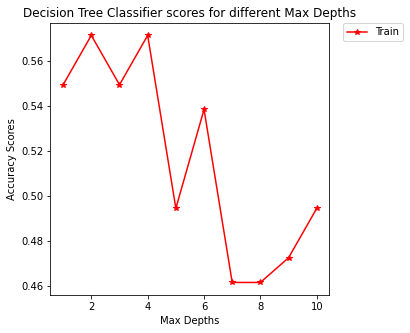

In [ ]:
plt.figure(figsize =(5, 5)) 
plt.plot([i for i in range(1,11)], decision_depth_scores, marker='*', color = 'red', label='Train')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.xlabel('Max Depths')
plt.ylabel('Accuracy Scores')
plt.title('Decision Tree Classifier scores for different Max Depths')

# End of Assignment 3